# Способы отрисовки поверхностей

## Расчеты SES поверхностей

Вот тут обозрены всякие методы (https://doi.org/10.1101/294025)
Какие методы можно выделить: 

Аналитические (Connoly PQMS https://doi.org/10.1016/0263-7855(93)87010-3, MSMS https://doi.org/10.1002/(SICI)1097-0282(199603)38:3<305::AID-BIP4>3.0.CO;2-Y). Плюсы: правильная поверхность, обычно в комплекте с триангуляцией, реализовано в пимоле. Минусы: долго, сложно, написано на эльфийском 200 лет назад. 

Решеточные (LSMS https://doi.org/10.1016/j.jmgm.2006.02.012, EDTSurf https://doi.org/10.1371/journal.pone.0008140). Плюсы: скорость (нет), треугольники. Минусы: нет нормалей, затратно (клятые воксели), написано на эльфийском.

dmasif (https://doi.org/10.1101/2020.12.28.424589) - градиентный спуск по функции smooth distance, фильтрация, сабсемплинг. Плюсы: быстро. Минусы: нестабильно, невоспроизводимо, лысые вогнутые места (хотя по факту должно быть наоборот), непроходимо для градиента. 

### Setup

In [19]:
# Dependencies
'''
! wget https://zhanggroup.org/EDTSurf/EDTSurf
! chmod u+x EDTSurf
! pip install -r requirements.txt

'''

In [ ]:
# Download and protonate some pdbs
'''
! mkdir protein_data/
! python3 download_pdb.py -pdb 3B01
'''

### Метрики сходства для облаков точек

In [16]:
import sys,importlib
import torch
import os
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline 

In [26]:
try:
    importlib.reload(sys.modules['dmasif_surface'])
    importlib.reload(sys.modules['compute_SES'])
    importlib.reload(sys.modules['losses'])

except KeyError:
    pass

from dmasif_surface import get_smooth_surface
from compute_SES import computeMSMS, computeEDTSurf
from losses import chamfer_distance, hausdorff_distance, distribution

pdb_dir='protein_data/'


In [22]:
pdb_file=pdb_dir+os.listdir(pdb_dir)[0]

print(pdb_file)

msms_vert, msms_face, msms_norm=computeMSMS(pdb_file)
edt_vert, edt_face=computeEDTSurf(pdb_file)
dmasif_vert, dmasif_norm = get_smooth_surface(pdb_file)


protein_data/3B01.pdb


EDTSurf работает оооочень долго. 

/home/domain/data/prog/miniconda3/envs/dmasif_upd/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



MSMS point number: 115177
dmasif point number: 31314
EDTSurf point number: 229836


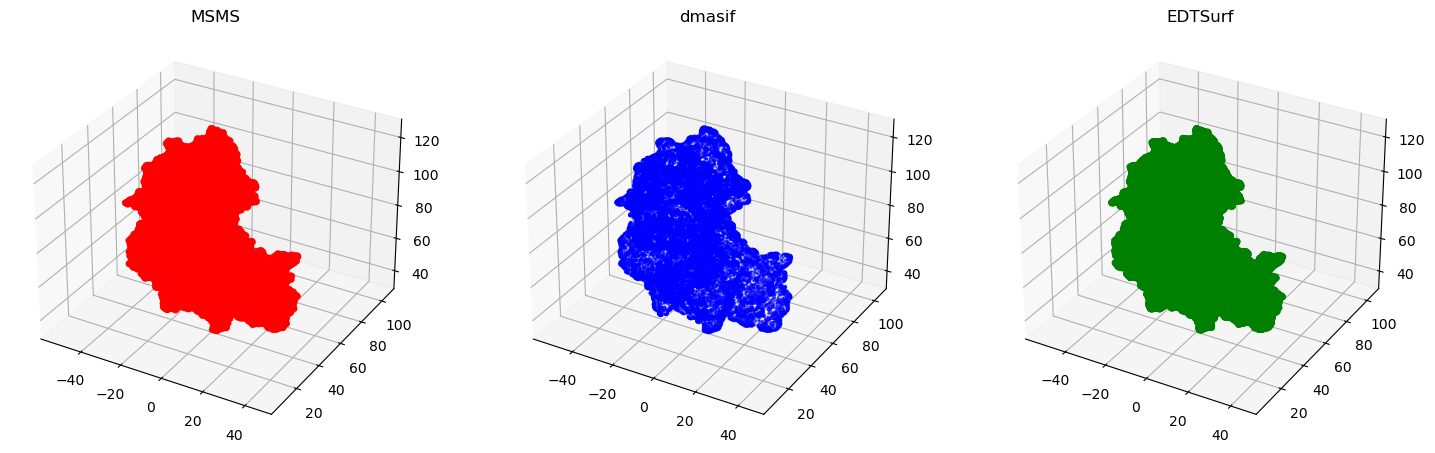

In [23]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*edt_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('EDTSurf')

fig.show()

print('MSMS point number:', msms_vert.shape[0])
print('dmasif point number:', dmasif_vert.shape[0])
print('EDTSurf point number:', edt_vert.shape[0])

Рассчитаем метрики, сравним способ dmasif с MSMS как идеальной моделью

In [24]:
d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, torch.Tensor(msms_vert), dmasif_norm, torch.Tensor(msms_norm), single_directional=True)
d_haus_dist=hausdorff_distance(dmasif_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',d_ch_loss.item())
print('Normal distance:',d_norm_loss.item())
print('Hausdorff distance:',d_haus_dist.item())

Chamfer distance: 0.5748410224914551
Normal distance: 0.17819952964782715
Hausdorff distance: 6.675432205200195


In [27]:
msms_dist=distribution(torch.Tensor(msms_vert), reduction='max')
dmasif_dist=distribution(dmasif_vert, reduction='max')
print('MSMS distribution:',msms_dist.item())
print('dMaSIF distribution:',dmasif_dist.item())

MSMS distribution: 24.50531768798828
dMaSIF distribution: 11.648719787597656


### Простой метод

Сделаем самую простую брутфорс модель, которая будет просто рисовать рандомные точки по SAS поверхности, удалять внутренние точки, перемещать точки на радиус пробы и усреднять грид кластерингом для получения условной SES поверхности. 

In [28]:
try:
    importlib.reload(sys.modules['simple_surface'])
except KeyError:
    pass
from simple_surface import get_simple_surface

In [29]:
my_vert, my_norm = get_simple_surface(pdb_file)


16320 3 300


Проблема: для получения приемлевого количества точек нужно генерировать по 300 точек на атом, что может создать ограничения по памяти. При этом большая часть этих точек в итоге никак не сыграет, а будет отфильтрована. Была сделана попытка генерировать и отфильтровывать точки символьными функциями, но keops не работает с таким количеством измерений. 

MSMS point number: 115177
dMaSIF point number: 31314
Mine point number: 26426


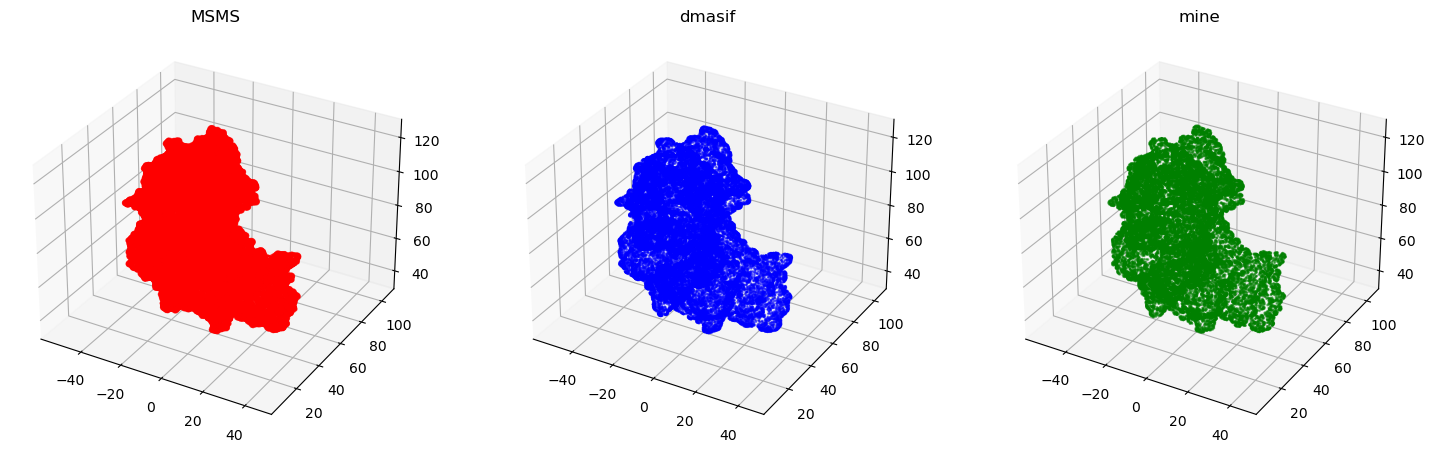

In [30]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*my_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('mine')

print('MSMS point number:', msms_vert.shape[0])
print('dMaSIF point number:', dmasif_vert.shape[0])
print('Mine point number:', my_vert.shape[0])


In [31]:
m_ch_loss, m_norm_loss=chamfer_distance( my_vert, torch.Tensor(msms_vert), my_norm, torch.Tensor(msms_norm), single_directional=True)
m_haus_dist=hausdorff_distance(my_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',m_ch_loss.item())
print('Normal distance:',m_norm_loss.item())
print('Hausdorff distance:',m_haus_dist.item())

my_dist=distribution(my_vert, reduction='max')
print('Distribution:',my_dist.item())

Chamfer distance: 0.6975382566452026
Normal distance: 0.1700257509946823
Hausdorff distance: 9.146618843078613
Distribution: 6.197305679321289


In [32]:
loss_col=chamfer_distance( my_vert, torch.Tensor(msms_vert),reduction=None)

fig=px.scatter_3d(x=my_vert[:,0],y=my_vert[:,1],z=my_vert[:,2], color=loss_col[0][0][:,0].log())
fig.update_traces(marker={'size': 2})
fig.update_layout(
    autosize=False, 
    width=1200, 
    height=800,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

In [33]:
pd.DataFrame(index=['dmasif','mine'], columns=['chamfer','normal','hausdorff','distribution'],
             data=[[d_ch_loss.item(),d_norm_loss.item(), d_haus_dist.item(), dmasif_dist.item()],
                   [m_ch_loss.item(),m_norm_loss.item(), m_haus_dist.item(), my_dist.item()]])

,chamfer,normal,hausdorff,distribution
dmasif,0.574841,0.178200,6.675432,11.648720
mine,0.697538,0.170026,9.146619,6.197306


Результаты брутфорс метода сравнимы с методом dmasif

## Способы триангуляции

Это пока не нужно

In [ ]:
import numpy as np
import k3d
from compute_triangles import split_triangles, delaunay

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#cells=split_triangles(my_vert)
cells=delaunay(my_vert)

In [ ]:
plot = k3d.plot()
plot+=k3d.points(my_vert, point_size=0.2, shader='flat')
plot+=k3d.mesh(my_vert,cells, side='double', color=0x32ff31)

plot.display()

Output()